In [1]:
import os
from google.colab import drive
from google.colab import files
import random
import pandas as pd
import time
import numpy as np
import h5py
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from torch.nn.modules.activation import LeakyReLU
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install torchinfo
from torchinfo import summary

In [3]:
!mkdir data
!cp /content/gdrive/MyDrive/Colab\ Notebooks/PPG\ Classifier/data_PPG_Dalia_RNN_5.h5 /content/data

In [4]:
os.chdir("/content/data")

In [4]:
## 10-fold
indexbase=list(range(1,16))
indextest=random.sample(indexbase, 2)
indexkfold=indexbase.copy()
indexkfold.remove(indextest[0])
indexkfold.remove(indextest[1])
list_indexval=[]
for k in range(0,10):
    list_indexval.append([indexkfold[int((2*k)%13)],indexkfold[(2*k+1)%13]])

In [5]:
## 1-fold
indexbase=list(range(1,16))
indextest=random.sample(indexbase, 2)
indexkfold=indexbase.copy()
indexkfold.remove(indextest[0])
indexkfold.remove(indextest[1])
list_indexval=[]
for k in range(0,1):
    list_indexval.append([indexkfold[int((2*k)%13)],indexkfold[(2*k+1)%13]])

In [ ]:
indextest

[8, 2]

In [7]:
h5f = h5py.File('data_PPG_Dalia_RNN.h5','r')
data=h5f["data_S1/1/bvp_sp"][:]
h5f.close()

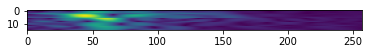

In [9]:
bvp_sp=data[1]
plt.imshow(bvp_sp)

In [6]:
def minmaxnorm(x,verif):
  if (np.max(x)-np.min(x))==0:
    verif=0
  return (x-np.min(x))/(np.max(x)-np.min(x)),verif
class ds_ppg(Dataset):
    def __init__(self, list_dic):
        self.samples = []
        for dic in list_dic:
            for i in range (0,len(dic["bvp"])):
                label=(60/np.mean(dic["hr"][i]))/250
                verif=1
                bvp_sp,verif=minmaxnorm(dic["bvp_sp"][i],verif)                
                accx_sp,verif=minmaxnorm(dic["accx_sp"][i],verif)
                accy_sp,verif=minmaxnorm(dic["accy_sp"][i],verif)
                accz_sp,verif=minmaxnorm(dic["accz_sp"][i],verif)
                if verif==1:
                  self.samples.append((np.array([bvp_sp,accx_sp,accy_sp,accz_sp]),label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, id):
        return self.samples[id]

In [7]:
def gen_list_dict_test(indextest):
    out=[]
    names=['bvp','accx','accy','accz','peak','bvp_sp','accx_sp','accy_sp','accz_sp','hr']
    for i in indextest:
      for n in range(1,5):
        dic={}
        for name in names:
          dic[name]=h5f["data_S{}/{}/{}".format(i,n,name)][:]
        out.append(dic.copy())
    return out
def gen_list_dict_kfold(indexkfold,indexval):
    out_val=[]
    out_train=[]
    names=['bvp','accx','accy','accz','peak','bvp_sp','accx_sp','accy_sp','accz_sp','hr']
    for i in indexkfold:
      for n in range(1,5):
        dic={}
        for name in names:
          dic[name]=h5f["data_S{}/{}/{}".format(i,n,name)][:]
        if i in indexval:
            out_val.append(dic.copy())  
        else:
            out_train.append(dic.copy())
    return out_train,out_val

In [8]:
"""
Finally the structure is  Dataset_kfold has 10 elements which are [Dataset training, Dataset val]
Dataset_test is the testing dataset.
Each Dataset has X samples and each sample is [data,label]
"""

h5f = h5py.File('data_PPG_Dalia_RNN_5.h5','r')
Datasets_kfold=[]
for indexval in list_indexval:
    list_dict_train,list_dict_val=gen_list_dict_kfold(indexkfold,indexval)
    Datasets_kfold.append([ds_ppg(list_dict_train),ds_ppg(list_dict_val)])
list_dict_test=gen_list_dict_test(indextest)
Dataset_test=ds_ppg(list_dict_test)
h5f.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [9]:
del(list_dict_train)
del(list_dict_test)

In [69]:
def conv2d(h,k,s,p):
    return 1+(h+2*p-(k-1)-1)/s

In [107]:
conv2d(56,4,4,0)

14.0

In [19]:
from torch.nn.modules import dropout
def init_weight(m):
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        torch.nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        torch.nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)



class Model(nn.Module):
    def __init__(self, ngpu):
        super(Model, self).__init__()
        self.ngpu = ngpu
        self.kernel=32
        self.nnModel = nn.Sequential(
            nn.Conv2d(
                in_channels=4,
                out_channels=self.kernel,
                kernel_size=[3,10],
                stride=[1,1],
                padding=0,
                bias=True
            ),#13x248
            nn.MaxPool2d(
                kernel_size=[1,2],
                stride=[1,2],
                padding=0
            ),#13x124
            nn.BatchNorm2d(self.kernel),
            #nn.LeakyReLU(0.2),#13x124
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Conv2d(
                in_channels=self.kernel,
                out_channels=2*self.kernel,
                kernel_size=[1,5],
                stride=[1,1],
                padding=0,
                bias=True
            ),#13x120
            nn.MaxPool2d(
                kernel_size=[1,2],
                stride=[1,2],
                padding=0
            ),#13x60
            nn.BatchNorm2d(2*self.kernel),
            #nn.LeakyReLU(0.2),#13x60
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Conv2d(
                in_channels=2*self.kernel,
                out_channels=4*self.kernel,
                kernel_size=[1,5],
                stride=[1,1],
                padding=0,
                bias=True
            ),#13x56
            nn.MaxPool2d(
                kernel_size=[1,4],
                stride=[1,4],
                padding=0
            ),#13x14
            nn.BatchNorm2d(4*self.kernel),
            #nn.LeakyReLU(0.2),#13x28
            nn.Tanh(),
            nn.Dropout(0.3),
        )
        self.RNN=nn.RNN(input_size=14*self.kernel*4,hidden_size=16,num_layers=2,batch_first=True,dropout=0.2)
        self.Linear_1=nn.Linear(16,1,bias=True)
        self.Linear_2=nn.Linear(8,1,bias=True)
    def forward(self, input):
        output_conv=self.nnModel(input)
        input_rnn=nn.Flatten(2,3)(torch.transpose(output_conv,1,2))
        output_rnn=self.RNN(input_rnn)[1][-1]
        out=self.Linear_1(output_rnn)
        #out=nn.Tanh()(out)
        #out=self.Linear_2(out)
        out=nn.Sigmoid()(out)
        return out.view(-1)

def custom_loss(weight_peak,y,yhat):
  t=torch.abs((y-yhat)*torch.where(yhat>0,weight_peak,1))
  return torch.mean(t.view(-1))

In [20]:
net= Model("cuda").to("cuda")
net.apply(init_weight)

Model(
  (nnModel): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 10), stride=(1, 1))
    (1): MaxPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Tanh()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1))
    (11): MaxPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Tanh()
    (14): Dropout(p=0.3, inplace=False)
  )
  (RNN): RNN(1792, 16, num_layers=2, batch_first=True, dropout=0.2

In [21]:
summary(net)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       3,872
│    └─MaxPool2d: 2-2                    --
│    └─BatchNorm2d: 2-3                  64
│    └─Tanh: 2-4                         --
│    └─Dropout: 2-5                      --
│    └─Conv2d: 2-6                       10,304
│    └─MaxPool2d: 2-7                    --
│    └─BatchNorm2d: 2-8                  128
│    └─Tanh: 2-9                         --
│    └─Dropout: 2-10                     --
│    └─Conv2d: 2-11                      41,088
│    └─MaxPool2d: 2-12                   --
│    └─BatchNorm2d: 2-13                 256
│    └─Tanh: 2-14                        --
│    └─Dropout: 2-15                     --
├─RNN: 1-2                               29,504
├─Linear: 1-3                            17
├─Linear: 1-4                            9
Total params: 85,242
Trainable params: 85,242
Non-train

In [ ]:
lr=0.001
beta1=0.9
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))

In [22]:
manualSeed=1
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(manualSeed)

In [26]:
from tqdm import tqdm
def training(net,dataloader_t,dataloader_v,num_epochs,fold):
  Loss = []
  Lossv= []
  lr=0.00001/2
  beta1=0.9
  optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999))
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=5,verbose=True)
  for epoch in tqdm(range(num_epochs)):
      L_v=[]
      L_t=[]
      net.train()
      for i, dataj in enumerate(dataloader_t, 0):
          net.train()
          net.zero_grad()
          x=dataj[0].float().to("cuda")
          yhat=dataj[1].float().to("cuda")
          y=net(x)
          err_t=nn.MSELoss()(y.view(batch_size).float(),yhat.float())
          err_t.backward()
          optimizer.step()
          L_t.append(err_t.item())
      for i, dataj in enumerate(dataloader_v, 0):
        net.eval()     
        x=dataj[0].float().to("cuda")
        yhat=dataj[1].float().to("cuda")
        y=net(x)
        err_v=nn.L1Loss()(y.view(batch_size).float(),yhat.float())
        L_v.append(err_v.item())
      err=np.mean(L_t)
      std=np.std(L_t)
      errv=np.mean(L_v)
      print("erreur train {} et erreur val {}".format(err*250,errv*250))
      stdv=np.std(L_v)
      Loss.append([err,std])
      Lossv.append([errv,stdv])
      #scheduler.step(errv)
      #print("erreur : {} et variance : {}".format(errv,stdv))
      #torch.save(net.state_dict(), "net/net_"+str(fold)+"_epoch_"+str(epoch)+".pth")

  return [Loss,Lossv]


In [ ]:
np.array(L[0][1][-5:])[:,0]

array([6.05778139, 5.67043335, 5.71418047, 5.49097667, 6.23486425])

In [24]:
dataset_t=Datasets_kfold[0][0]
dataset_v=Datasets_kfold[0][1]
batch_size=64
num_workers=2
dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)

In [27]:
training(net,dataloader_t,dataloader_v,60,1)

  2%|▏         | 1/60 [00:23<23:13, 23.62s/it]

erreur train 0.6845129360582539 et erreur val 8.066323723161608


  3%|▎         | 2/60 [00:47<22:48, 23.59s/it]

erreur train 0.6791847620964594 et erreur val 8.062704081023982


  5%|▌         | 3/60 [01:10<22:22, 23.55s/it]

erreur train 0.6739483070569188 et erreur val 7.943043495334095


  7%|▋         | 4/60 [01:34<21:59, 23.57s/it]

erreur train 0.6735427850603579 et erreur val 7.992999407080866


  8%|▊         | 5/60 [01:57<21:37, 23.59s/it]

erreur train 0.663468910696333 et erreur val 7.985913911633355


 10%|█         | 6/60 [02:21<21:13, 23.59s/it]

erreur train 0.6625981633244733 et erreur val 8.059078525993035


 12%|█▏        | 7/60 [02:45<20:48, 23.56s/it]

erreur train 0.6707590831454934 et erreur val 7.91674067782198


 13%|█▎        | 8/60 [03:08<20:25, 23.57s/it]

erreur train 0.6526607103687736 et erreur val 7.939024349312774


 15%|█▌        | 9/60 [03:32<20:01, 23.56s/it]

erreur train 0.6572160561508325 et erreur val 7.884390233419568


 17%|█▋        | 10/60 [03:55<19:37, 23.54s/it]

erreur train 0.6526059288624173 et erreur val 7.877321106468816


 18%|█▊        | 11/60 [04:19<19:13, 23.54s/it]

erreur train 0.64886570751657 et erreur val 7.882908170895396


 20%|██        | 12/60 [04:42<18:51, 23.58s/it]

erreur train 0.640915622923746 et erreur val 7.78079174271376


 22%|██▏       | 13/60 [05:06<18:33, 23.69s/it]

erreur train 0.6461046110827385 et erreur val 7.819155539325672


 23%|██▎       | 14/60 [05:30<18:12, 23.74s/it]

erreur train 0.642913165109505 et erreur val 7.873486677224902


 25%|██▌       | 15/60 [05:54<17:46, 23.70s/it]

erreur train 0.6352097530046888 et erreur val 7.910661911926896


 27%|██▋       | 16/60 [06:17<17:21, 23.68s/it]

erreur train 0.6367001468035636 et erreur val 7.885309083641863


 28%|██▊       | 17/60 [06:41<16:57, 23.66s/it]

erreur train 0.6349360319486599 et erreur val 7.878149437496988


 30%|███       | 18/60 [07:05<16:34, 23.68s/it]

erreur train 0.6393724464531613 et erreur val 7.9212284399022295


 32%|███▏      | 19/60 [07:28<16:09, 23.65s/it]

erreur train 0.6313625346729658 et erreur val 7.838367873119364


 33%|███▎      | 20/60 [07:52<15:47, 23.69s/it]

erreur train 0.6228062212622101 et erreur val 7.758976298672476


 35%|███▌      | 21/60 [08:16<15:24, 23.71s/it]

erreur train 0.6263276521177206 et erreur val 7.986554788867775


 37%|███▋      | 22/60 [08:40<15:01, 23.73s/it]

erreur train 0.624618656846935 et erreur val 8.006118874487688


 38%|███▊      | 23/60 [09:03<14:37, 23.72s/it]

erreur train 0.6118128966913753 et erreur val 7.7980808216890845


 40%|████      | 24/60 [09:27<14:13, 23.71s/it]

erreur train 0.6182462366073147 et erreur val 7.744265596295218


 42%|████▏     | 25/60 [09:51<13:49, 23.69s/it]

erreur train 0.6186592386990426 et erreur val 7.739927334938761


 43%|████▎     | 26/60 [10:14<13:25, 23.68s/it]

erreur train 0.6110160219215823 et erreur val 7.869499393825908


 45%|████▌     | 27/60 [10:38<13:01, 23.70s/it]

erreur train 0.6060697112022149 et erreur val 7.882745501002391


 47%|████▋     | 28/60 [11:02<12:36, 23.65s/it]

erreur train 0.6071549417561807 et erreur val 7.731538091739305


 48%|████▊     | 29/60 [11:26<12:16, 23.76s/it]

erreur train 0.6043182815295538 et erreur val 7.734986976887897


 50%|█████     | 30/60 [11:50<11:54, 23.81s/it]

erreur train 0.6045223680919134 et erreur val 7.742293869151914


 52%|█████▏    | 31/60 [12:13<11:29, 23.76s/it]

erreur train 0.6031828085714777 et erreur val 7.744192048612473


 53%|█████▎    | 32/60 [12:37<11:04, 23.72s/it]

erreur train 0.5958295041245849 et erreur val 7.790342067107023


 55%|█████▌    | 33/60 [13:00<10:39, 23.69s/it]

erreur train 0.5959681071466528 et erreur val 7.709038035153485


 57%|█████▋    | 34/60 [13:24<10:15, 23.68s/it]

erreur train 0.5873847717094743 et erreur val 7.6302584367904736


 58%|█████▊    | 35/60 [13:48<09:51, 23.68s/it]

erreur train 0.5903289020939303 et erreur val 7.619957831560922


 60%|██████    | 36/60 [14:11<09:27, 23.64s/it]

erreur train 0.5834480596467494 et erreur val 7.7501527140948845


 62%|██████▏   | 37/60 [14:35<09:02, 23.60s/it]

erreur train 0.5870519902190051 et erreur val 7.666040175065077


 63%|██████▎   | 38/60 [14:59<08:39, 23.63s/it]

erreur train 0.5840987110806514 et erreur val 7.667513369924302


 65%|██████▌   | 39/60 [15:22<08:16, 23.62s/it]

erreur train 0.5842332939209882 et erreur val 7.665533301078801


 67%|██████▋   | 40/60 [15:46<07:52, 23.64s/it]

erreur train 0.5805671513293399 et erreur val 7.645985071393226


 68%|██████▊   | 41/60 [16:09<07:29, 23.65s/it]

erreur train 0.5715935384937291 et erreur val 7.743095282277615


 70%|███████   | 42/60 [16:33<07:05, 23.66s/it]

erreur train 0.5686630987819167 et erreur val 7.66873967049898


 72%|███████▏  | 43/60 [16:57<06:42, 23.70s/it]

erreur train 0.5692305378072898 et erreur val 7.571421010861937


 73%|███████▎  | 44/60 [17:21<06:18, 23.67s/it]

erreur train 0.5703920309784852 et erreur val 7.576636082271664


 75%|███████▌  | 45/60 [17:44<05:54, 23.65s/it]

erreur train 0.5714892318127401 et erreur val 7.631615980146385


 77%|███████▋  | 46/60 [18:08<05:31, 23.65s/it]

erreur train 0.5598246437437664 et erreur val 7.605000097545788


 78%|███████▊  | 47/60 [18:32<05:07, 23.67s/it]

erreur train 0.5624563029257803 et erreur val 7.66905348265557


 80%|████████  | 48/60 [18:55<04:44, 23.67s/it]

erreur train 0.5610970596711511 et erreur val 7.546038876066534


 82%|████████▏ | 49/60 [19:19<04:20, 23.66s/it]

erreur train 0.5609912071816726 et erreur val 7.572677442066961


 83%|████████▎ | 50/60 [19:42<03:56, 23.65s/it]

erreur train 0.5597768572296181 et erreur val 7.546563897442689


 85%|████████▌ | 51/60 [20:06<03:32, 23.65s/it]

erreur train 0.5567474909184966 et erreur val 7.517596552644274


 87%|████████▋ | 52/60 [20:30<03:09, 23.65s/it]

erreur train 0.5509476415818916 et erreur val 7.574162248307638


 88%|████████▊ | 53/60 [20:53<02:45, 23.65s/it]

erreur train 0.5433467000545132 et erreur val 7.567685945026523


 90%|█████████ | 54/60 [21:17<02:21, 23.63s/it]

erreur train 0.5464205185157341 et erreur val 7.711347581135284


 92%|█████████▏| 55/60 [21:41<01:58, 23.62s/it]

erreur train 0.5413251171464049 et erreur val 7.4840395061446605


 93%|█████████▎| 56/60 [22:04<01:34, 23.64s/it]

erreur train 0.5454995857934425 et erreur val 7.659453255452698


 95%|█████████▌| 57/60 [22:28<01:10, 23.62s/it]

erreur train 0.5429950295130707 et erreur val 7.494304416258987


 97%|█████████▋| 58/60 [22:51<00:47, 23.62s/it]

erreur train 0.5429977842062707 et erreur val 7.54164637689539


 98%|█████████▊| 59/60 [23:15<00:23, 23.60s/it]

erreur train 0.5357821649545992 et erreur val 7.407520043415774


100%|██████████| 60/60 [23:39<00:00, 23.65s/it]

erreur train 0.5330624417868138 et erreur val 7.549085202057371


[[[0.0027380517442330155, 0.0008298915283961432],
  [0.0027167390483858376, 0.0008238080265865161],
  [0.002695793228227675, 0.0007733704534126286],
  [0.0026941711402414317, 0.000788685476031021],
  [0.002653875642785332, 0.0007351120270152162],
  [0.0026503926532978933, 0.0007838447856737205],
  [0.0026830363325819734, 0.0008098152922507822],
  [0.0026106428414750943, 0.0007743380880516086],
  [0.0026288642246033297, 0.0007561393001624824],
  [0.0026104237154496693, 0.00078822453900063],
  [0.0025954628300662802, 0.0007957444708699129],
  [0.002563662491694984, 0.0007805345627434276],
  [0.002584418444330954, 0.0007618877346418679],
  [0.00257165266043802, 0.0007925086197949522],
  [0.0025408390120187554, 0.0007959554197960944],
  [0.0025468005872142543, 0.0007721137703718412],
  [0.0025397441277946395, 0.000779366749281677],
  [0.002557489785812645, 0.0007729962459070321],
  [0.002525450138691863, 0.0007583375830804546],
  [0.0024912248850488404, 0.0006902718493058107],
  [0.0025053

In [114]:
a=next(iter(dataloader_t))

In [41]:
input=torch.concat([torch.unsqueeze(a[0],1),torch.unsqueeze(a[1],1),torch.unsqueeze(a[2],1),torch.unsqueeze(a[3],1)],axis=1)

IndexError: ignored

In [20]:
input.shape

torch.Size([32, 4, 15, 257])

In [ ]:
training(net,dataloader_t,dataloader_v,150,1)

In [64]:
a=next(iter(dataloader_t))

In [132]:
x=a[0].float().to("cuda")
yhat=a[1].float().to("cuda")

In [35]:
torch.min(a[0][0][0].view(-1))

tensor(4.4600)

In [116]:
x[0][0]

tensor([[0.0250, 0.0610, 0.1151,  ..., 0.1080, 0.0975, 0.0881],
        [0.3953, 0.4000, 0.4133,  ..., 0.0926, 0.0836, 0.0745],
        [0.5683, 0.5681, 0.5672,  ..., 0.0676, 0.0713, 0.0754],
        ...,
        [0.1636, 0.1628, 0.1605,  ..., 0.0955, 0.0944, 0.0929],
        [0.0492, 0.0496, 0.0507,  ..., 0.0989, 0.0913, 0.0837],
        [0.0216, 0.0215, 0.0214,  ..., 0.0416, 0.0423, 0.0432]],
       device='cuda:0')

In [133]:
net.eval()
y=net(x)

In [134]:
yhat*250

tensor([ 67.8578, 169.1453,  92.7287,  76.3251, 100.1739, 104.8862, 103.1334,
        105.9993,  87.3058,  84.4988,  60.9524,  79.4483,  90.2586, 103.7838,
         48.6076, 104.4614, 134.8315, 101.2658,  93.5825, 111.9534, 127.0401,
         78.5009, 105.9310,  74.7243,  77.1429,  46.7153,  88.7633, 128.8014,
         67.1329,  88.9346,  87.8830, 101.6471, 130.7110, 108.2368, 124.1379,
        108.0878,  82.7586,  89.5917,  82.9672,  66.5127, 117.1089, 129.6129,
        104.4803,  77.2809,  93.6585,  69.0234,  70.4587, 161.8952, 100.5236,
         89.7662, 102.4000,  89.7896,  99.4304,  76.9710,  83.8733, 118.0449,
        118.4941,  83.4783,  77.1601,  78.4474,  76.7148,  75.5906,  85.3333,
         80.8232], device='cuda:0')

In [135]:
y*250

tensor([ 80.3667, 165.3854,  90.9574,  95.7336,  98.4458,  94.9842,  88.2742,
        111.6985,  86.4082,  95.0465,  88.0342,  93.0962,  91.4060,  92.9612,
         55.3744, 101.8964, 143.4395, 108.9039,  93.0473, 100.0497, 124.2134,
         79.9629,  99.2563,  77.6105,  79.4743,  55.4216,  92.7820, 130.8923,
         81.7816,  91.4073,  91.2155,  90.1859, 127.7747,  98.7656, 103.7675,
        108.3701,  90.8953,  87.4547,  90.4432,  78.6992, 119.9648, 124.4974,
         96.8884,  78.7350,  91.7013,  86.5586,  70.7190, 164.6824, 101.7424,
         87.3433,  95.9361,  92.7333, 109.2481,  81.6275,  80.4288, 113.6643,
        100.8157,  85.3453,  79.4506,  90.0069,  77.9493,  83.0847,  89.4579,
         96.5297], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
!rm -r net
!mkdir net
manualSeed=1
g = torch.Generator()
g.manual_seed(manualSeed)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
L=[]
i=0
for ds in Datasets_kfold:
  net= Model("ngpu").to("cuda")
  net.apply(init_weight)
  batch_size=64
  num_workers=2 
  dataset_t=ds[0]
  dataset_v=ds[1]
  dataloader_t = torch.utils.data.DataLoader(dataset_t,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  dataloader_v = torch.utils.data.DataLoader(dataset_v,batch_size=batch_size,shuffle=True,num_workers=num_workers,worker_init_fn=seed_worker,generator=g, drop_last=True)
  L.append(training(net,dataloader_t,dataloader_v,50,i))
  i+=1
  print(i)

100%|██████████| 50/50 [05:35<00:00,  6.72s/it]


1


100%|██████████| 50/50 [05:29<00:00,  6.58s/it]


2


100%|██████████| 50/50 [05:34<00:00,  6.69s/it]


3


100%|██████████| 50/50 [05:30<00:00,  6.60s/it]


4


100%|██████████| 50/50 [05:36<00:00,  6.73s/it]


5


100%|██████████| 50/50 [05:33<00:00,  6.67s/it]


6


100%|██████████| 50/50 [05:34<00:00,  6.69s/it]


7


100%|██████████| 50/50 [05:37<00:00,  6.74s/it]


8


100%|██████████| 50/50 [05:32<00:00,  6.66s/it]


9


100%|██████████| 50/50 [05:40<00:00,  6.80s/it]

10


In [ ]:
L

In [ ]:
f = open ("results.txt", "w")
for i in range (0,len (L)) :                
    f.write ( str (L[i][0]) + "\t" + str(L[i][1]))    
    f.write ("\n")                           
f.close ()   

In [ ]:
#!cp -r /content/data/net /content/gdrive/MyDrive/Colab\ Notebooks/PPG\ Classifier/
!cp /content/data/results.txt /content/gdrive/MyDrive/Colab\ Notebooks/PPG\ Classifier/

In [ ]:
L[1]

[[[26.22340187446667, 137.4019873520616],
  [10.201140678971191, 1.9183937365008457],
  [8.962720092202796, 1.82258203781836],
  [7.7660380134491325, 1.6069600089820468],
  [7.203880370803218, 1.569474008125859],
  [6.857637066495874, 1.476926938916955],
  [6.554138836150613, 1.416495908969986],
  [6.2842126522885, 1.4177936461754441],
  [6.026046406375906, 1.3289360773470273],
  [5.794594808842967, 1.2704238559231282],
  [5.692707860893239, 1.2928003071123002],
  [5.51029466556721, 1.242589300181282],
  [5.394748122639995, 1.199342325778536],
  [5.212574175553895, 1.1805313130129158],
  [5.162644982337952, 1.1247980898276315],
  [5.021361923282915, 1.094876199036336],
  [4.920128318129993, 1.0820410933694813],
  [4.790412721738138, 1.024661766097016],
  [4.725684947166287, 1.0398844009557815],
  [4.644660347472123, 1.0733295826043039],
  [4.500907672070414, 0.9933763074251917],
  [4.444829794878516, 1.0010524809668242],
  [4.433914753990095, 1.0006702642186835],
  [4.303593074933428, 

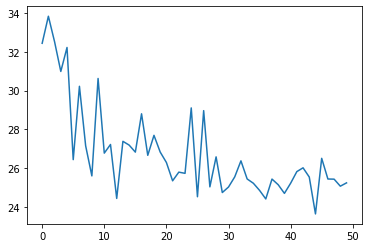

In [ ]:
plt.plot(np.array(L[2][1])[:,0])

In [ ]:
list_indexval

[[1, 2],
 [3, 4],
 [5, 6],
 [7, 9],
 [10, 12],
 [13, 14],
 [15, 1],
 [2, 3],
 [4, 5],
 [6, 7]]

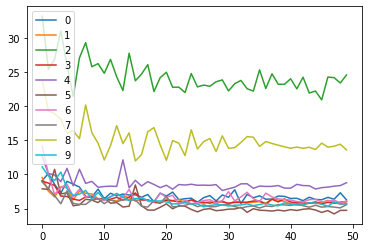

In [ ]:
i=0
for elem in L:
  plt.plot(np.array(elem[1])[:,0],label=str(i))
  i=i+1
plt.legend(loc="upper left")

In [ ]:
best_model=[]
for elem in L:
  i=np.argmin(np.array(elem[1])[:,0])
  best_model.append([elem[1][i][0],elem[1][i][1]])


In [ ]:
best_model

[[5.0970557593938075, 1.0743052170673415],
 [11.726587232396993, 2.509383601278615],
 [5.203251361846924, 1.2863865432387878],
 [8.69639709833506, 1.500277152489221],
 [6.539975645487782, 1.3587263372880427],
 [9.508396544850859, 1.6713214081043566],
 [5.557737471012587, 1.3703434987581862],
 [6.117825209026268, 1.1156455663648626],
 [15.877437507528565, 2.8819604296967283],
 [5.962595968668751, 1.1891585665456073]]

(array([5., 1., 0., 1., 1., 0., 1., 0., 0., 1.]),
 array([ 5.09705576,  6.17509393,  7.25313211,  8.33117028,  9.40920846,
        10.48724663, 11.56528481, 12.64332298, 13.72136116, 14.79939933,
        15.87743751]),
 <a list of 10 Patch objects>)

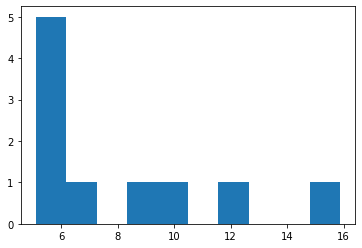

In [ ]:
plt.hist(np.array(best_model)[:,0])

In [ ]:
np.mean(np.array(best_model)[:,0])

8.569737312765305

In [ ]:
np.std(np.array(best_model)[:,0])

3.1117292781478483

(array([4., 1., 2., 1., 0., 0., 0., 0., 1., 1.]),
 array([1.07150776, 1.27888221, 1.48625667, 1.69363112, 1.90100557,
        2.10838003, 2.31575448, 2.52312893, 2.73050339, 2.93787784,
        3.1452523 ]),
 <a list of 10 Patch objects>)

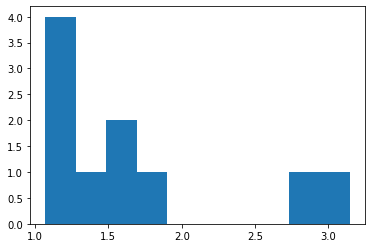

In [ ]:
plt.hist(np.array(best_model)[:,1])

In [ ]:
np.mean(np.array(best_model)[:,1])

1.7038595831556207

In [ ]:
np.std(np.array(best_model)[:,1])

0.6905385917800653

In [ ]:
L=[[[[20.97811090977486, 44.09123753936951], [10.666726299471117, 2.1376807388758663], [9.268858811986728, 1.8461165013110428], [8.464892997516422, 1.8057753466401656], [7.794193800509445, 1.6739879839586995], [7.544690096785077, 1.604607148045903], [7.23690496827048, 1.6327877301288067], [6.896536533288129, 1.5887066103235459], [6.6987798703624195, 1.458897046196953], [6.562683719506101, 1.4414167311646882], [6.332982486783676, 1.4364490218233597], [6.159043724768431, 1.3292111761348946], [6.063395675711744, 1.357367974924657], [5.949328844941507, 1.353159814321686], [5.773026228889706, 1.2972908788254893], [5.659151955539473, 1.251906788636822], [5.56594348939385, 1.2277869552314662], [5.413893780370397, 1.2214485673132454], [5.381809101330013, 1.1903829601331612], [5.29023372970541, 1.1976701119271906], [5.140571370055982, 1.1513578339408055], [5.089936589944394, 1.100799076450889], [4.998915991288784, 1.0905945730960813], [4.840019421940401, 1.077932797948493], [4.81702013176883, 1.0595843113811643], [4.781116859493606, 1.0618885233110815], [4.661352727122194, 0.9690069935739091], [4.561461802855564, 0.9811645990371207], [4.522114874027532, 0.9515106996365272], [4.430646224675842, 0.946724483521474]],	[[14.13992838138144, 1.802783416810453], [10.613564982185505, 1.5339565758958595], [7.167944130422445, 1.337703484463], [8.092800629534844, 1.3973208206686627], [7.321419877759645, 1.3659471517454882], [6.616154691829893, 1.252353889757843], [10.268533456809406, 1.5081261347946628], [7.962039959826592, 1.4676325964456378], [7.497307963916736, 1.5302567440344015], [9.54475944596463, 1.4561264641023337], [6.536708126208879, 1.3001391722141198], [6.363926111552108, 1.3105532973598852], [9.574750068002961, 1.454454429385932], [6.865893265418021, 1.3903027819213112], [7.153808952697529, 1.4252775352120668], [7.720865619138598, 1.4887898422938233], [6.589032604245682, 1.4462781700572747], [6.677655236747432, 1.5094132677899275], [6.391457233921628, 1.3421706495419934], [6.2759966384000885, 1.2949732763261246], [7.639549719891425, 1.3902897581117575], [8.836099596481041, 1.353569054835293], [6.275952842402722, 1.2489337832300862], [7.012007020056467, 1.3691286887523622], [6.557367598438615, 1.3367714517804394], [6.9774948785225845, 1.362243040612861], [7.454846925841046, 1.5018934984118393], [7.661998611534654, 1.395778847653637], [6.505236927433647, 1.3991095626412249], [6.327721917761208, 1.3812699867384803]]],
[[[29.540267600862204, 124.3110271917613], [11.393259077713799, 2.302534383212321], [9.826824930223752, 2.09620026666782], [8.869701637127154, 1.9049176682338642], [8.114196693048, 1.7295113955913155], [7.685297270091668, 1.7656350061074304], [7.31555548774221, 1.6170863644640265], [7.026108118506409, 1.568475100706013], [6.781188055519063, 1.5488299627993423], [6.543266609035885, 1.4973043117152742], [6.414373361970001, 1.4623290366346033], [6.179648343365551, 1.4120044482370318], [6.034759035211125, 1.3699465456170157], [5.863474753884338, 1.4070827150725052], [5.731004851789147, 1.305841573333119], [5.6055700209650325, 1.287970627893459], [5.532719081498702, 1.2925597045446777], [5.423225449540684, 1.2886084004469418], [5.3741545906796615, 1.2306152101047694], [5.254283294042371, 1.2291340187233053], [5.191815008116901, 1.2057593733910306], [5.0736353799975955, 1.1619700225038527], [5.0234624288956535, 1.1506909464963], [4.837423590210937, 1.0767555019098995], [4.777015516500045, 1.0752832554932328], [4.732766272681999, 1.0760861934267851], [4.675432704841241, 1.0429855548329718], [4.629012272666186, 1.045176142164543], [4.531300432292012, 0.991752917473151], [4.444649497091298, 1.0143123119891455]],	[[10.18047892833696, 1.4413965947029117], [10.782241004342247, 1.4267020370370682], [8.461662345462376, 1.2548508498017534], [7.451867517177349, 1.2244583778314682], [6.315333889376733, 1.0959075973785761], [7.936116922713523, 1.1635532670038184], [9.193379379942426, 1.2443882651122389], [7.46469626375424, 1.2458046386515045], [6.447883089810716, 1.1972578469003652], [6.967494930417734, 1.1851046501742049], [7.282950153487557, 1.179956943198569], [6.279495132439453, 1.1236998593087257], [5.998167971983605, 1.1040248263144687], [6.429904689925546, 1.174726358489201], [6.78645230877784, 1.3257828643782086], [6.87028846091267, 1.3020295767775059], [7.778631307745493, 1.2417116806066015], [6.605169806429135, 1.237680157105628], [7.265610623103316, 1.1827004395431902], [7.80685723896095, 1.3780979394087793], [6.528592910390601, 1.281566641164642], [8.62391876234376, 1.3095622383422778], [6.415650659137302, 1.1657856439281404], [6.4423062775724675, 1.2044893484146426], [6.5463466883560235, 1.2177677959568092], [6.318432850649708, 1.3225546754491528], [7.1559669099828245, 1.3086630507213135], [6.401853669928821, 1.230445234342253], [6.388929853302604, 1.1935301301364525], [6.536537943775081, 1.2161604972451954]]],
[[[17.779064754156575, 35.96111114283384], [9.383443622018808, 1.967503815428354], [7.989413088738324, 1.5778072915424624], [7.3087111954673185, 1.4952806616946042], [7.009691134956588, 1.4614288214287927], [6.703716099539468, 1.3573904337849805], [6.423384357211598, 1.3508497848549352], [6.268312725434668, 1.317492956483527], [6.057621219704713, 1.2860484101161784], [5.989490194732564, 1.2857704634892677], [5.787330485023929, 1.2286786636512015], [5.745481805547923, 1.2261658986902428], [5.59334788037297, 1.2102866767157516], [5.480780463994935, 1.1782194698122184], [5.338629423502672, 1.1512163498704193], [5.225932938236731, 1.117960798586562], [5.137939011456562, 1.0783775634744843], [5.080151909451152, 1.1136136391634868], [4.936071364190491, 1.037389895659574], [4.854382786798319, 1.0570506586011463], [4.769965421955451, 1.031841999654781], [4.696456712187326, 1.0047980174583229], [4.597870107188177, 0.9731280053662871], [4.558519002527889, 0.9685654899994969], [4.452318882704573, 0.9403787448035327], [4.407085688169612, 0.9082446965794247], [4.3454291479928155, 0.9001955588834633], [4.228247022153531, 0.9097727326539798], [4.259676674117282, 0.8985048221160301], [4.182238096573028, 0.9297792658633462]],	[[19.92619387856845, 3.176220063913881], [17.00514653962234, 3.4052177351021697], [16.026534233422115, 3.03625605911998], [16.923665204541436, 3.3229415929341233], [14.546269962705415, 3.0744522847799267], [15.50305260132099, 3.3443074437527924], [13.005544437211135, 2.872384553640469], [15.207013373539366, 3.2932456000503336], [14.111814322964898, 3.250978171746422], [13.80798132337373, 3.1225567181512806], [16.475896445636092, 3.311923275602854], [15.87997472697291, 3.4746797103100158], [14.572276232160371, 3.0387361737326324], [15.046908644972177, 3.237850297926729], [14.537929959132754, 3.455084874198948], [16.237041789087755, 3.2536318927766317], [15.863603710306101, 3.249494036724777], [14.173554186985411, 3.1573986877823104], [14.632708194338042, 2.815830752460363], [13.834495317524878, 3.3119235697895753], [14.544455278330835, 3.344693652542011], [13.352693010198658, 2.9233258317695983], [13.684388543819558, 3.0499580630988548], [14.104644887200717, 2.88553463536937], [13.936216191587777, 3.4058378647280834], [14.139755347679401, 3.364849777897589], [13.504098946472695, 3.1748213245658716], [13.769942425037252, 3.0977162209221487], [15.50187522625101, 3.479789175545843], [12.836290586405786, 3.202710830413223]]],
[[[25.045031502842903, 64.78624285725246], [11.403370871208608, 2.331740248579325], [9.815257261817655, 1.9338174202428204], [8.403118435293436, 1.8751522617837721], [7.805411864692966, 1.7587878979019578], [7.0440348903648555, 1.59330121087216], [6.9101063429067535, 1.577111872778384], [6.614547273609787, 1.531222532426586], [6.333174176514149, 1.46260970988369], [6.2217827962401016, 1.474971709618929], [6.03022752997155, 1.4121642618131847], [5.849723964463919, 1.3673134938314488], [5.727151674063255, 1.3291370112924439], [5.713686922409882, 1.3266540133557194], [5.482671599990378, 1.2936271501335888], [5.379900818690658, 1.2379371759073006], [5.260413599510987, 1.267272542229993], [5.180641973080735, 1.2177249923856712], [5.091272474887471, 1.2140379196789652], [5.010475885278235, 1.1362350602617644], [4.947565549363692, 1.1005320566808097], [4.855216049589217, 1.1062556459576665], [4.748036697972566, 1.1002208827791993], [4.729332505570103, 1.1071865792250717], [4.650389641523361, 1.0647959767906732], [4.573913242823134, 1.0932673737047331], [4.419540285365656, 1.0038055147762412], [4.408775590204944, 1.0251739950069703], [4.3695271335697425, 0.9693049436878067], [4.304940460249782, 1.005723399216208]],	[[12.642285604734678, 1.9188295374665734], [13.069941358676749, 1.6745975289454216], [10.214035128074263, 1.5822075420179544], [9.150408190649909, 1.6611564043848017], [11.094086260408968, 1.79876680742327], [10.907932158142444, 1.6240900771465672], [11.299352310799264, 1.655091115601627], [9.742675133193321, 1.7282451548619278], [8.95528895330245, 1.7190182570256323], [10.255173727352187, 1.6817557224740793], [10.031447504478072, 1.7517988914613998], [9.462394452923514, 1.5790535280712954], [9.253953272771652, 1.7550707307051088], [10.85239838817405, 1.7346243590617478], [9.940070831637586, 1.6506945286090646], [8.929716793266502, 1.4599759549683957], [9.527205408309877, 1.5167550541533072], [9.427798381643406, 1.5875198494242877], [9.064118692773649, 1.618297006990512], [9.330771131405038, 1.537866521151284], [9.422748215870508, 1.7030637359415721], [10.89931547687781, 1.812894156728113], [9.99046364346066, 1.710206028577736], [10.568550161413244, 1.7477156206660776], [8.379361102940033, 1.5859917337302676], [9.071762346392893, 1.588769107666636], [9.412337652964942, 1.5114207860161057], [8.664123409963482, 1.5335331697812442], [9.891392335928545, 1.775494112205437], [10.952274199158069, 1.9379052248443494]]],
[[[25.98931518389333, 75.23518017364282], [11.044811226026987, 2.250478111962613], [9.530438180572244, 1.913080383955898], [8.79659155267541, 1.7904609915888048], [8.082179747441764, 1.7380551057134512], [7.538638814803092, 1.6965674063594354], [7.232153409431057, 1.6416264774847449], [6.970817496058761, 1.5703863296623095], [6.743635384626286, 1.52037164716695], [6.594302051490353, 1.5900613150606882], [6.345685846382572, 1.4664925319356572], [6.117323784898686, 1.4326759408502965], [6.012482726766217, 1.4295992661138635], [5.891915206947634, 1.3351751762432267], [5.7944935749294935, 1.3480348972833769], [5.642135708402562, 1.262266286278681], [5.570453871802617, 1.281807843878024], [5.501713125295536, 1.2045926106491773], [5.348157793123235, 1.1950055642405804], [5.229131153514309, 1.1479812990488147], [5.197920277714729, 1.1599118099003625], [5.089073976521851, 1.1313142790118023], [5.056884377073216, 1.092115562184508], [4.908108930914633, 1.073584183669534], [4.8399881723747455, 1.0704281628284344], [4.7761973265999105, 1.0548345303424578], [4.725325848146151, 1.0370048946522206], [4.619011289169712, 1.0245757633324708], [4.61544821851997, 1.0118538564086386], [4.497748685139482, 0.9867871595276797]],	[[16.47825443006882, 2.6396613102446493], [12.202014205510142, 2.223933439649834], [10.43193910952888, 2.131878932199648], [9.829203512458925, 1.889915056870055], [9.942060908587825, 2.3521453805215486], [9.929721434652222, 1.800212371538798], [11.459968990922363, 2.282576830659778], [8.361291202737764, 1.8302132033530774], [9.432229980195384, 2.04983011069202], [8.64305815556927, 1.8331420834984395], [9.624246802314484, 1.9135145328839205], [8.030824404197718, 1.7325606754956158], [7.514065302932689, 1.6734545473434213], [7.88877321609845, 1.5640827906728882], [8.004649399934452, 1.6947360150001545], [10.042673732248113, 1.9211173340947487], [7.321553460938146, 1.6235577712409959], [7.056524117528809, 1.5542935089584184], [6.956011960871445, 1.5764199817804867], [6.9696591902245135, 1.5651953473745785], [7.250437269769973, 1.6111769942925764], [8.926026951606577, 1.7916717194011034], [7.581030615766196, 1.6066655637275968], [7.094033975166296, 1.7016674672543508], [7.176380818363898, 1.6483143798858109], [7.4049403830537575, 1.5442600425627315], [7.563971830889923, 1.7392426733680182], [7.352533259686895, 1.5214562054024858], [9.25243422884118, 1.7166113871703788], [7.392690275701716, 1.5918419117827343]]],
[[[21.367215152820158, 57.59654351734731], [10.776053793125302, 2.1837506828556568], [9.259292980398273, 1.9255065530439688], [8.225452206775975, 1.7138273391825793], [7.671766896783216, 1.6845297731870188], [7.318752742622913, 1.6009088026653542], [6.963492278953134, 1.469727545799165], [6.801883300197343, 1.500766071671218], [6.495521857439694, 1.4077338335068885], [6.338888779477102, 1.3686982565285502], [6.229917805126379, 1.3991507563523458], [5.984170277031533, 1.3700638981365652], [5.880588695523633, 1.310835243808188], [5.745672251007887, 1.2469259070499537], [5.635139737988266, 1.2112337256201189], [5.523385003870524, 1.187815242800629], [5.42573820284079, 1.170724665197598], [5.335037500210904, 1.2116388475245639], [5.1782139273598675, 1.1478695024300776], [5.158291790410682, 1.1568499580609353], [4.983869824801662, 1.1123038405864225], [4.966990533447763, 1.1020662139620734], [4.849427214179276, 1.0614357794544287], [4.774652653979259, 1.0401816080783235], [4.6932172043827745, 1.0046921244198717], [4.63983844201185, 1.003832837494159], [4.597216964390508, 1.0224023511971445], [4.556001973370036, 1.00665742945039], [4.45041108302597, 0.933927824173908], [4.4756487395526845, 1.036405730063731]],	[[13.769397837127569, 2.4260518354401186], [11.803665801146185, 1.801668512817935], [11.756653520997487, 1.9243157740335595], [9.845456543984069, 1.5773670662938306], [10.334923620912965, 1.7977870390131534], [11.667063519075343, 2.2122049696460233], [10.151385780523032, 1.6068145572763028], [10.241577784824734, 1.993213747762202], [15.016508950933304, 2.4792836146013486], [12.683071373986653, 2.3179273407394585], [12.859777292824516, 2.3941008187904287], [14.010660238592344, 2.595529059300863], [10.526780166553454, 1.9826327270449084], [9.944453166918157, 2.1247479746754676], [9.568331600595336, 1.9305878555110707], [14.021507841552618, 2.988639541898163], [12.436400424391598, 2.3840981487354345], [10.495207846391336, 2.347617162218693], [14.456907353926974, 2.662753610509866], [10.188634711073378, 2.191839622780382], [10.660660295885325, 2.035018457831265], [10.472740916698152, 1.9038948546531689], [11.821760627253427, 2.3336200057825622], [10.846279352790049, 2.4120747536951948], [11.07165671482739, 2.3545417654130185], [11.717045133104795, 2.434267260576704], [11.147037168872673, 2.2038724158865044], [10.362981067410894, 2.058704390210277], [11.935981873776976, 2.4945488190508964], [12.771514932465644, 2.7754937421517343]]],
[[[20.934043394021337, 71.38059912335719], [10.835993469385576, 2.2137667376256656], [9.45792756686036, 1.8287629284375906], [8.867860806237966, 1.8111799919409934], [8.222847950084047, 1.7258572458564083], [7.629955743775942, 1.6160424538009501], [7.247499083037152, 1.603166311585364], [6.93556618050755, 1.5301802408248568], [6.748265557576224, 1.4349992131220026], [6.496547111509982, 1.4359320365243018], [6.374446724877932, 1.4246567339456562], [6.141198492955163, 1.3973196103416774], [5.955325169869118, 1.3214336788622592], [5.814691190476193, 1.3152620707500848], [5.714597637428663, 1.29177870397054], [5.57294574785607, 1.2461470842253703], [5.523364434067491, 1.2156949118754705], [5.446312526445738, 1.1999289596445004], [5.292457148042649, 1.1852318592098408], [5.217039352312138, 1.1357943194585378], [5.145344244560022, 1.141134003483872], [5.049476003615644, 1.1545033409627357], [4.961521388972617, 1.043789820083926], [4.899054774127081, 1.051360892074807], [4.808411016904246, 1.0542344663276577], [4.716013826468852, 1.0126607201029896], [4.673684339404731, 1.001316771370777], [4.596652706178071, 0.9999086102078274], [4.516928315942824, 0.9878351451181471], [4.5059803313921885, 0.9678964435361472]],	[[11.017978059218617, 1.6435717509934233], [9.708428182851955, 1.4860560302940382], [8.074107359411117, 1.4509923503068678], [7.349119118536903, 1.2933571275050886], [7.386543727546149, 1.3991635658392674], [8.386366545930784, 1.5734467076053327], [6.930745740954795, 1.3503601617663503], [6.156287843368474, 1.3213084896408869], [9.089721892210429, 1.471402910446295], [7.70787220322684, 1.3477247640961532], [6.287926912307739, 1.3282393781810842], [6.352473574184747, 1.3017937281297056], [6.206793502028962, 1.3003982214981342], [6.588320209738914, 1.2701493037463751], [6.611913589056065, 1.3935712088678678], [6.588955082696922, 1.3220141018723777], [6.520004082261846, 1.3656202391763863], [8.243431430630917, 1.4369026501959796], [7.296439002962148, 1.319600303688075], [8.293554298886646, 1.433383435375859], [7.466275945584872, 1.455849825144493], [7.86413578326336, 1.4223207013922452], [7.062804328368398, 1.3571756830434465], [8.617554200276007, 1.3159815349373474], [6.726241920771224, 1.3918552734261147], [6.600502695483661, 1.4983595971219574], [6.220034980595335, 1.2691280956287634], [6.771798621402698, 1.3823062153098569], [6.978006300408295, 1.4687650555710299], [6.732892972253235, 1.462166984564614]]],
[[[20.90901034241171, 54.1208682833625], [11.067776056771805, 2.2112487196025046], [9.407570883466246, 1.9403930989808196], [8.523495633955644, 1.8214409662276827], [8.013319041042216, 1.7396255860032341], [7.5551260942574965, 1.6371926771596315], [7.137312875395114, 1.5855409376152265], [7.008250365453479, 1.5761584953175847], [6.705764373558787, 1.5417159163829124], [6.490987273620516, 1.4531543403171037], [6.301679166760186, 1.4019464750939252], [6.27112029051952, 1.42827102471538], [6.126544410305659, 1.3909578803209977], [5.876086712039272, 1.3161590362901656], [5.7684091830238025, 1.2846549830079501], [5.7319804296861046, 1.3071124158163363], [5.614840792332655, 1.2687977669975212], [5.521567220862281, 1.2464377345868272], [5.348882405762576, 1.2161084711824734], [5.246802381562844, 1.1750171237744367], [5.115269789269047, 1.148761536087279], [5.066899816324943, 1.1290790489593177], [4.921969293847262, 1.0763322596394655], [4.8522637944685565, 1.0952406950115992], [4.808127042750453, 1.0632055012694703], [4.70883024011384, 1.0282825784260543], [4.681306403419849, 1.0046705168951868], [4.56557467153538, 1.0087913414180634], [4.52520148089164, 0.9719621247581889], [4.48287561031668, 0.9759062828664736]],	[[8.782967643304305, 1.3352746096686399], [8.376828247850591, 1.2095621734745519], [8.13032105655381, 1.2293986770510423], [6.685943827484593, 1.0930584396494964], [6.240317782669356, 1.1358045540375397], [5.921164956959811, 1.0527521426068138], [5.729928137678089, 1.1748632253272808], [5.721402192657644, 1.0643264370478696], [5.493513230121497, 1.0831498514063362], [5.493856405669993, 1.1817821671260638], [6.390431256005258, 1.3093912161138468], [5.704839747060429, 1.113254184230721], [6.037036008003986, 1.2352546137009663], [6.378065158020366, 1.3110435400480367], [5.842823656219425, 1.2276231151118988], [5.486612285628463, 1.0556712187870363], [5.960374036521623, 1.2132390682191796], [6.126505302660393, 1.129002742208455], [5.377585412877979, 1.096309733043126], [5.261299958734801, 1.1387711028648135], [5.701308729973706, 1.1906241615655404], [5.577454817114455, 1.1818697832882714], [5.453829655141542, 1.1223701214198079], [5.713042313402349, 1.1135217126797494], [5.574718791427034, 1.1357308274046811], [5.646870174191215, 1.0878583182741146], [5.93905744137186, 1.1479664495025257], [5.638346437251929, 1.2290732433577785], [5.412846397269856, 1.129776536651096], [6.133309257752968, 1.2679115227454645]]],
[[[17.99309412617266, 34.79907859163589], [8.950775878498979, 1.8616742652706049], [7.61065058714515, 1.5721784521130024], [7.0438182708123005, 1.506253898236913], [6.708968347990861, 1.471575387487538], [6.305943760220505, 1.332541716378164], [6.074821892720635, 1.2957693109467154], [5.958347518342876, 1.2879688012701462], [5.74517325064864, 1.2449281719106764], [5.660707950275836, 1.289319393968606], [5.457584865055287, 1.201540390728817], [5.393845592790953, 1.2041834853556888], [5.254324978321237, 1.208397565338153], [5.085481135377201, 1.1376608326976065], [5.078042771360918, 1.1465784416116125], [4.910440824076098, 1.0826427040427624], [4.814520062043749, 1.0518356776424296], [4.758510458927888, 1.0902837619162336], [4.617893950455385, 1.0377644062469074], [4.5775387597020805, 1.0199527774328625], [4.518931701028379, 0.9949082074711105], [4.439778840510219, 0.9718163943485839], [4.25485030986586, 0.9595388266106694], [4.274708890867486, 0.9875516689505105], [4.1780919608133855, 0.9047905751281722], [4.14490689459783, 0.9379054422921649], [4.0964905657565875, 0.8913833233333704], [4.057885231326683, 0.9056329339983137], [3.966125256977284, 0.903258957403374], [3.9012118566099465, 0.8575236975872909]],	[[20.0209492706671, 3.2717605198056], [15.117600223328594, 2.7870978443506065], [17.682755048266685, 3.1368993498821984], [18.78774473143787, 3.381064549565049], [16.677463278953205, 3.2759990908838152], [16.49567119585097, 3.2616978214810888], [19.283810519175248, 3.269163523695324], [16.296863148852093, 3.3398153059795024], [16.972405839049443, 3.4614558538047326], [16.69281302927263, 3.132034672779446], [15.537051805635778, 3.2103577290250946], [17.541538547555746, 3.12371676202577], [17.427542271099025, 3.2469610205966246], [15.798864414467628, 3.3070837541089024], [13.81871240894969, 2.95959356763375], [14.090650963866336, 2.8402998265280206], [15.504161804810634, 3.088911984156117], [15.714287468780624, 3.1880384587271213], [15.236147586476928, 3.082042143531003], [14.648633368754636, 2.935892270143624], [15.545579009770517, 3.122656451561059], [18.047430869178903, 3.3127700366795283], [15.112848763681871, 3.264179499579608], [16.198559737787015, 3.291237703219727], [16.201455887186402, 3.1983699919171205], [15.588051347367024, 3.093603152338428], [15.561712595643897, 3.281892985562921], [14.307746571530863, 3.0849701816450956], [16.23582087327379, 3.3678321335276364], [14.870379695493584, 3.0856810864426634]]],
[[[23.597551759146643, 73.54119147525289], [11.028722642287807, 2.0635555419983573], [9.36855299641767, 1.9347293947419035], [8.460896296451098, 1.8556731623279645], [7.9883249469316535, 1.7634147139056098], [7.689874436442308, 1.6912712982426232], [7.346933054173086, 1.5906410927453847], [7.037023080459104, 1.5961439680274438], [6.874183639453777, 1.5597153342737542], [6.708807491880703, 1.51197558309394], [6.546030652335309, 1.483564785588513], [6.317901095693193, 1.4152066673670727], [6.185528091401879, 1.3902084085811581], [6.085168422363561, 1.427131741216822], [6.003640919532676, 1.3447017789259361], [5.823734264674149, 1.3115763737427941], [5.715107732244677, 1.2590418624200461], [5.616971849612989, 1.2690314158323284], [5.50012183893384, 1.2644462570125123], [5.404191373840091, 1.2132296925224757], [5.300287768127411, 1.1869224891391752], [5.229703836397236, 1.18883339900868], [5.134642478675041, 1.1550515190429862], [4.972318011006032, 1.098639152971745], [4.965916165842472, 1.11195198437177], [4.870921700175979, 1.1352005639175127], [4.746021971927853, 1.0307430032645906], [4.751514955924877, 1.0649844202957897], [4.6680505059835475, 1.0215567951520985], [4.587172986328445, 1.0090231414359827]],	[[11.033779559540132, 1.5412614252053818], [8.236174483140896, 1.4095298498917008], [7.057571205265847, 1.217379007632938], [7.30190221409956, 1.2326100821160908], [6.62841937462782, 1.2730731864967946], [7.968077870752539, 1.507240335485444], [8.129002498964542, 1.5707915188009323], [7.005919117769192, 1.4117965721174839], [6.965321595378468, 1.222141343534729], [5.99306665223463, 1.1821945790306825], [6.702209755063497, 1.3054728661334445], [7.301512401482276, 1.4713105514165152], [6.417876177608307, 1.3412690912536884], [5.485187045762459, 1.0634797271754608], [7.248451968400681, 1.3411771861794468], [5.9746399787959135, 1.2402325870376218], [6.277596493928635, 1.27322372199411], [8.16887154702331, 1.661654912037995], [6.0341940673954815, 1.1997082109351849], [5.6918763032258655, 1.1075616898595255], [6.424075746008391, 1.3720613839028453], [6.34604934396779, 1.3646764160436577], [6.4552720648776125, 1.3496904825356], [6.706299086778366, 1.0991951076877353], [7.454788456103898, 1.5024057225866525], [6.184384968887836, 1.3160416259833754], [6.150628663517012, 1.308159386645214], [6.598602213102953, 1.420689629272236], [5.7942460973324375, 1.2818122787663637], [6.528032415467434, 1.3827377081520158]]]]


In [ ]:
best_model=[]
for elem in L:
  i=np.argmin(np.array(elem[1])[:,0])
  best_model.append([elem[1][i][0],elem[1][i][1]])


In [ ]:
best_model

[[6.275952842402722, 1.2489337832300862],
 [5.998167971983605, 1.1040248263144687],
 [12.836290586405786, 3.202710830413223],
 [8.379361102940033, 1.5859917337302676],
 [6.956011960871445, 1.5764199817804867],
 [9.568331600595336, 1.9305878555110707],
 [6.156287843368474, 1.3213084896408869],
 [5.261299958734801, 1.1387711028648135],
 [13.81871240894969, 2.95959356763375],
 [5.485187045762459, 1.0634797271754608]]

(array([3., 3., 0., 1., 0., 1., 0., 0., 1., 1.]),
 array([ 5.26129996,  6.1170412 ,  6.97278245,  7.82852369,  8.68426494,
         9.54000618, 10.39574743, 11.25148867, 12.10722992, 12.96297116,
        13.81871241]),
 <a list of 10 Patch objects>)

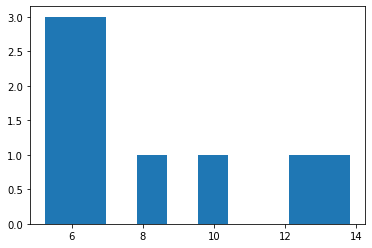

In [ ]:
plt.hist(np.array(best_model)[:,0])

In [ ]:
np.mean(np.array(best_model)[:,0])

8.073560332201435

In [ ]:
np.std(np.array(best_model)[:,0])

2.917022558852246

(array([4., 1., 2., 0., 1., 0., 0., 0., 1., 1.]),
 array([1.06347973, 1.27740284, 1.49132595, 1.70524906, 1.91917217,
        2.13309528, 2.34701839, 2.5609415 , 2.77486461, 2.98878772,
        3.20271083]),
 <a list of 10 Patch objects>)

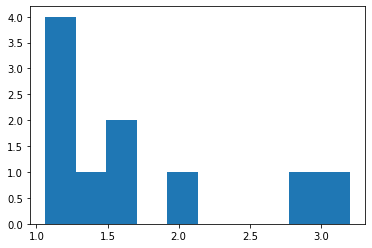

In [ ]:
plt.hist(np.array(best_model)[:,1])

In [ ]:
np.mean(np.array(best_model)[:,1])

1.7131821898294515

In [ ]:
np.std(np.array(best_model)[:,1])

0.7312051074249667

In [ ]:
training(net,dataloader_t,dataloader_v,20,1)

  5%|▌         | 1/20 [00:15<04:51, 15.36s/it]

erreur : 11.77574326821736 et variance : 1.6176352966681593


 10%|█         | 2/20 [00:30<04:36, 15.35s/it]

erreur : 13.718462038040162 et variance : 1.8525215359677123


 15%|█▌        | 3/20 [00:46<04:22, 15.44s/it]

erreur : 9.011296696322304 et variance : 1.427295727847398


 20%|██        | 4/20 [01:01<04:06, 15.39s/it]

erreur : 8.136172698225295 et variance : 1.4046418295115222


 25%|██▌       | 5/20 [01:16<03:50, 15.38s/it]

erreur : 10.9453151174954 et variance : 1.9206799547995708


 30%|███       | 6/20 [01:32<03:35, 15.38s/it]

erreur : 7.565270980766841 et variance : 1.2268991607274444


 35%|███▌      | 7/20 [01:47<03:20, 15.39s/it]

erreur : 7.513489833899906 et variance : 1.304457085331596


 35%|███▌      | 7/20 [01:56<03:36, 16.66s/it]


KeyboardInterrupt: ignored

In [ ]:
Loss = []
Lossv= []
num_epochs=10
for epoch in tqdm(range(num_epochs)):
    L_t=[]
    L_v=[]
    for i, dataj in enumerate(dataloader_t, 0):
        net.zero_grad()
        x=dataj[0].float().to("cuda")
        yhat=dataj[1].float().to("cuda")
        y=net(x)
        err_t=nn.L1Loss()(y.view(batch_size).float(),yhat.float())
        err_t.backward()
        optimizer.step()
        L_t.append(err_t.item())
    for i, dataj in enumerate(dataloader_v, 0):
      net.eval()     
      x=dataj[0].float().to("cuda")
      yhat=dataj[1].float().to("cuda")
      y=net(x)
      err_v=nn.L1Loss()(y.view(batch_size).float(),yhat.float())
      L_v.append(err_v.item())
    err=np.mean(L_t)
    errv=np.mean(L_v)
    Loss.append(err)
    Lossv.append(errv)
    print(Loss)

 10%|█         | 1/10 [00:13<02:01, 13.49s/it]

[165.62337000991988]


 20%|██        | 2/10 [00:26<01:47, 13.45s/it]

[165.62337000991988, 165.6219168694123]


 30%|███       | 3/10 [00:40<01:34, 13.51s/it]

[165.62337000991988, 165.6219168694123, 165.59233570098877]


 40%|████      | 4/10 [00:53<01:20, 13.49s/it]

[165.62337000991988, 165.6219168694123, 165.59233570098877, 165.63036268172056]


 50%|█████     | 5/10 [01:07<01:07, 13.47s/it]

[165.62337000991988, 165.6219168694123, 165.59233570098877, 165.63036268172056, 165.61218688280687]


 60%|██████    | 6/10 [01:20<00:53, 13.45s/it]

[165.62337000991988, 165.6219168694123, 165.59233570098877, 165.63036268172056, 165.61218688280687, 165.6122570556143]


 60%|██████    | 6/10 [01:24<00:56, 14.02s/it]


KeyboardInterrupt: ignored

In [ ]:
a=next(iter(dataloader_t))

In [ ]:
net.train()

Model(
  (nnModel): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 64, kernel_size=(3, 1), stride=(1, 1))
    (4): MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(3, 1), stride=(1, 1))
    (7): MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(128, 32, kernel_size=(3, 1), stride=(1, 1))
    (10): MaxPool2d(kernel_size=[4, 1], stride=[4, 1], padding=0, dilation=1, ceil_mode=False)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=224, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=1, bias=True)
    (16): ReL

In [ ]:
x=a[0].float().to("cuda")
yhat=a[1].float().to("cuda")

In [ ]:
y=net(x)

In [ ]:
err_t=nn.L1Loss()(y.view(batch_size).float(),yhat.float())
err_t.backward()
optimizer.step()
net.zero_grad()

In [ ]:
err_t

tensor(30.9375, device='cuda:0', grad_fn=<L1LossBackward0>)

In [ ]:
y

tensor([[165.8016],
        [ 33.7636],
        [ 31.0539],
        [ 57.0892],
        [ 91.0090],
        [ 28.1074],
        [ 27.4881],
        [ 87.9932],
        [ 34.3890],
        [ 53.1285],
        [ 85.7052],
        [ 37.3666],
        [120.6792],
        [125.2825],
        [138.5964],
        [ 98.4035],
        [193.1828],
        [ 82.7044],
        [ 26.4436],
        [ 87.7943],
        [ 78.0155],
        [ 83.9545],
        [ 98.0327],
        [ 76.6108],
        [ 46.9230],
        [ 62.7336],
        [ 58.6744],
        [120.2968],
        [ 32.6108],
        [ 64.3281],
        [204.8953],
        [ 38.2684]], device='cuda:0', grad_fn=<ReluBackward0>)

In [ ]:
yhat

tensor([118.7279, 110.9776,  96.2869,  76.1873,  58.3645,  75.4191,  96.3553,
        126.2010,  44.5619,  83.8293,  92.3645,  74.6208,  82.7265,  67.9275,
        108.1685,  84.1478,  95.7962,  73.1678,  98.0826, 107.9188,  83.2352,
         97.7297,  86.1141,  67.8115,  73.5284,  71.6300,  96.0140, 160.4942,
        115.7489,  96.8089, 153.2607,  80.8891], device='cuda:0')